In [44]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Importing necessary libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE          # oversampling
from imblearn.under_sampling import RandomUnderSampler  # undersampling
from imblearn.pipeline import Pipeline            # pipeline compatibile
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [45]:
# Importing the dataset
model_credit_card_data = pd.read_csv('Dataset/model_credit_card_data.csv')

## 1) Splitting data into train and test sets

The first step to build the model is to split the data into training and test sets. The training set is used to train the model, while the test set is used to evaluate its performance as it is one of the cardinal rules of machine learning to never test the model on the same data it was trained on. This is to ensure that the model is able to generalize well to unseen data. In this case, we will use 80% of the data for training and 20% for testing.


In [46]:
# Selecting the target variable and features
X = model_credit_card_data.drop(columns=['Credit_Score'])
y = model_credit_card_data['Credit_Score']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Save expected columns for future use
joblib.dump(X.columns.tolist(), "expected_columns.pkl")

# Split into training and test sets, with stratification to maintain the distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the number of observations in the training and test sets
print(f"Number of observations in the training set: {X_train.shape[0]}")
print(f"Number of observations in the test set: {X_test.shape[0]}")

Number of observations in the training set: 79718
Number of observations in the test set: 19930


## 2) Addressing imbalance in the dataset

As seen in the EDA section, the target variable presents an imbalanced distribution, with more than half of the observations belonging to the "Standard" categpry. This imbalance can lead to biased model predictions, as the model may favor the majority class.

In [47]:
# Show the number of observations per class of the target variable in the training set
print("Number of observations per class in the training set:")
total = len(y_train)
for cls, count in y_train.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set.")

print("-"*50)

print("Number of observations per class in the test set:")
total = len(y_test)
for cls, count in y_test.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the test set.")


Number of observations per class in the training set:
The number of observations with credit score = 2 is 42379. That is 53.16% of the observations in the training set.
The number of observations with credit score = 1 is 23162. That is 29.05% of the observations in the training set.
The number of observations with credit score = 3 is 14177. That is 17.78% of the observations in the training set.
--------------------------------------------------
Number of observations per class in the test set:
The number of observations with credit score = 2 is 10595. That is 53.16% of the observations in the test set.
The number of observations with credit score = 1 is 5791. That is 29.06% of the observations in the test set.
The number of observations with credit score = 3 is 3544. That is 17.78% of the observations in the test set.


As we can see, the distributions of the target variable are the same in both the training and test sets thanks to the stratified sampling. This ensures that the model is trained and tested on a representative sample of the data, which is important for evaluating its performance accurately.

### 2.1) Over-sampling the Minority Classes

To address class imbalance, we use the **SMOTE** (Synthetic Minority Over-sampling Technique) algorithm. SMOTE generates synthetic examples of the minority classes by interpolating between existing observations. This helps to balance the class distribution without simply duplicating existing data. 
By creating a more balanced dataset, SMOTE can help the model learn more equally from all classes, potentially improving its performance, especially on the previously underrepresented categories.


In [48]:
# Calculate the number of observations in the majority class
maj_size = y_train.value_counts().max()

# Ensure that ALL other classes are brought to that size
smote = SMOTE(
    sampling_strategy='not majority',  # Oversample all classes except the largest
    k_neighbors=5,                     # Reduce to 3 if classes 0/3 have < 5 examples
    random_state=42
)

# Create a new training set with oversampled balanced data
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Show the number of observations per class of the target variable in the training set after oversampling
print("Number of observations per class in the training set after oversampling:")
total = len(y_train_over)
for cls, count in y_train_over.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set after oversampling.")


Number of observations per class in the training set after oversampling:
The number of observations with credit score = 3 is 42379. That is 33.33% of the observations in the training set after oversampling.
The number of observations with credit score = 1 is 42379. That is 33.33% of the observations in the training set after oversampling.
The number of observations with credit score = 2 is 42379. That is 33.33% of the observations in the training set after oversampling.


### 2.2) Under-sampling the Majority Classes

Alternatively, it is possible to use **RandomUnderSampler** to reduce the number of observations in the majority classes down to the level of the minority class. This technique helps address class imbalance by ensuring that no class dominates the learning process.
Unlike SMOTE, which creates synthetic data, random undersampling simply removes examples from the majority classes, which can be faster but may risk losing valuable information.

This trade-off makes undersampling a good option since the dataset is already large and the majority class is over-represented. In this case, we can afford to lose some data from the majority class without significantly impacting the model's performance.



In [49]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize undersampler to reduce all classes to the size of the minority class
undersampler = RandomUnderSampler(
    sampling_strategy= 'majority',  # Undersample the majority class to the size of the minority class
    random_state=42
)

# Apply undersampling
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Display class distribution after undersampling
print("Number of observations per class in the training set after undersampling:")
total = len(y_train_under)
for cls, count in y_train_under.value_counts().items():
    percentage = (count / total) * 100
    print(f"The number of observations with credit score = {cls} is {count}. That is {percentage:.2f}% of the observations in the training set after undersampling.")


Number of observations per class in the training set after undersampling:
The number of observations with credit score = 1 is 23162. That is 44.96% of the observations in the training set after undersampling.
The number of observations with credit score = 2 is 14177. That is 27.52% of the observations in the training set after undersampling.
The number of observations with credit score = 3 is 14177. That is 27.52% of the observations in the training set after undersampling.


## 3) Decision Tree Classifier

Decision trees are a type of supervised learning algorithm that can be used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like structure where each node represents a feature and each branch represents a decision based on that feature.

### 3.0) Fetaure importance with bias

In [50]:
# Define the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report without oversampling or undersampling:")
print(classification_report(y_test, y_pred))

Classification Report without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96      5791
           2       0.96      0.97      0.96     10595
           3       0.96      0.94      0.95      3544

    accuracy                           0.96     19930
   macro avg       0.96      0.96      0.96     19930
weighted avg       0.96      0.96      0.96     19930



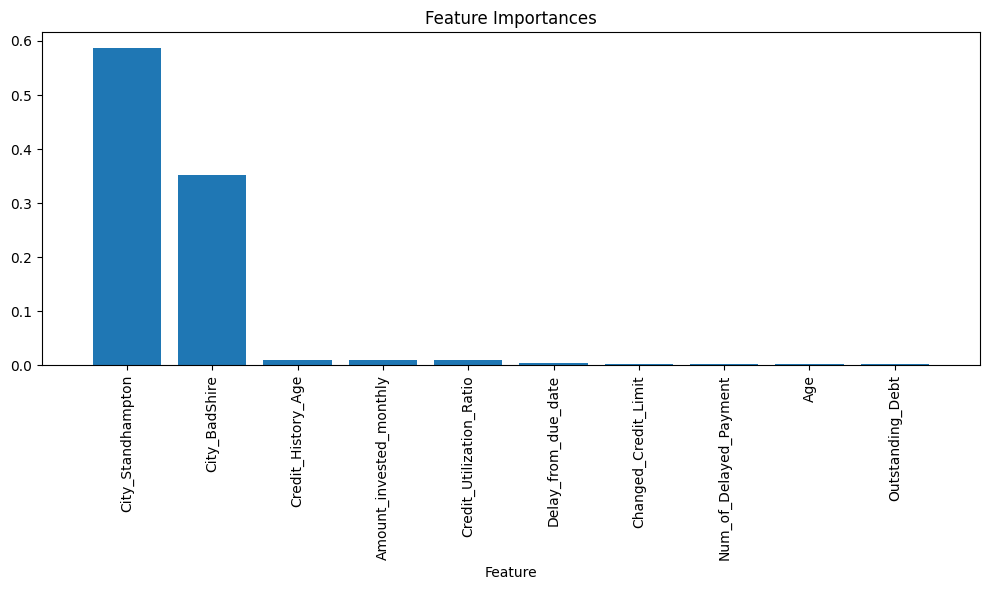

In [51]:
# Feature Importance
importances = decision_tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()

# Store the image in a file
plt.savefig('Outputs/feature_importances_with_bias.png')

# Show the plot
plt.show()

In [52]:
city_columns = ['City_Standhampton', 'City_BadShire', 'City_Lonton', 'City_ZeroVille']

# Drop the city columns from the dataset
X_train = X_train.drop(columns=city_columns)
X_test = X_test.drop(columns=city_columns)
X_train_over = X_train_over.drop(columns=city_columns)
X_train_under = X_train_under.drop(columns=city_columns)

### 3.1) Model Building and Evaluation

Three variations of the Decision Tree model were trained and evaluated:

1.  **Classic Model:** Trained on the original, imbalanced training dataset (`X_train`, `y_train`).
2.  **Oversampled Model:** Trained on the training dataset balanced using SMOTE (`X_train_over`, `y_train_over`).
3.  **Undersampled Model:** Trained on the training dataset balanced using RandomUnderSampler (`X_train_under`, `y_train_under`).

The performance of each model was assessed using the classification report and confusion matrix on the unseen test set (`X_test`, `y_test`).

**Classification Reports Summary:**

In [53]:
# Define the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report without oversampling or undersampling:")
print(classification_report(y_test, y_pred))

Classification Report without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.75      0.74      0.75      5791
           2       0.76      0.77      0.77     10595
           3       0.69      0.70      0.69      3544

    accuracy                           0.75     19930
   macro avg       0.74      0.74      0.74     19930
weighted avg       0.75      0.75      0.75     19930



**Classic Model:** Achieved an overall accuracy of 75%. The F1-scores were 0.75 for class 1 ('Poor'), 0.77 for class 2 ('Standard'), and 0.69 for class 3 ('Good'). This indicates reasonable performance but slightly lower effectiveness for the minority class ('Good').

In [54]:
# Define the Decision Tree model
decision_tree_model_over = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data with oversampling
decision_tree_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_over = decision_tree_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report with oversampling:")
print(classification_report(y_test, y_pred_over))

Classification Report with oversampling:
              precision    recall  f1-score   support

           1       0.75      0.75      0.75      5791
           2       0.77      0.76      0.77     10595
           3       0.69      0.72      0.71      3544

    accuracy                           0.75     19930
   macro avg       0.74      0.74      0.74     19930
weighted avg       0.75      0.75      0.75     19930



**Oversampled Model (SMOTE):** The accuracy remained at 75%. There was a slight improvement in recall for the minority class 3 ('Good') from 0.70 to 0.72, resulting in a marginally better F1-score (0.71) for this class. Performance for other classes was nearly identical to the classic model. This suggests SMOTE helped the model recognize the 'Good' credit score class slightly better without sacrificing overall accuracy.

In [55]:
# Define the Decision Tree model
decision_tree_model_under = DecisionTreeClassifier(random_state=42, max_features=10)

# Fit the model to the training data with undersampling
decision_tree_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_under = decision_tree_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report with undersampling:")
print(classification_report(y_test, y_pred_under))

Classification Report with undersampling:
              precision    recall  f1-score   support

           1       0.70      0.87      0.78      5791
           2       0.84      0.63      0.72     10595
           3       0.62      0.83      0.71      3544

    accuracy                           0.74     19930
   macro avg       0.72      0.78      0.74     19930
weighted avg       0.76      0.74      0.74     19930



**Undersampled Model (RandomUnderSampler):** Showed a slightly lower overall accuracy of 74%. However, it significantly improved the recall for both minority classes (Class 1: 0.87, Class 3: 0.83) compared to the classic model (Class 1: 0.74, Class 3: 0.70). This improvement came at the cost of reduced recall for the majority class 2 ('Standard') (0.63 vs 0.77). The F1-scores reflect this trade-off (Class 1: 0.78, Class 2: 0.72, Class 3: 0.71). Undersampling made the model better at identifying 'Poor' and 'Good' scores but worse at identifying 'Standard' scores.

**Confusion Matrix Analysis:**
The confusion matrices provide a visual representation of the classification accuracy:


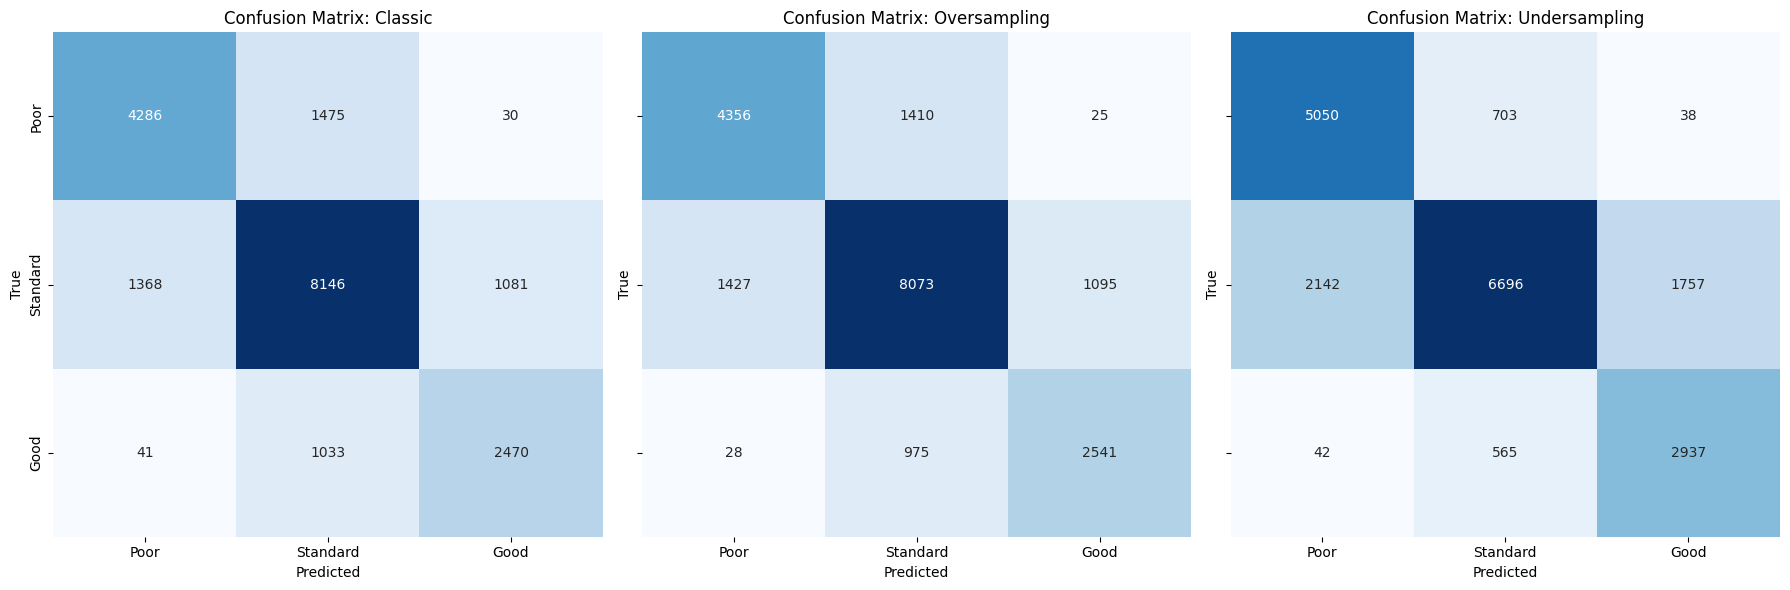

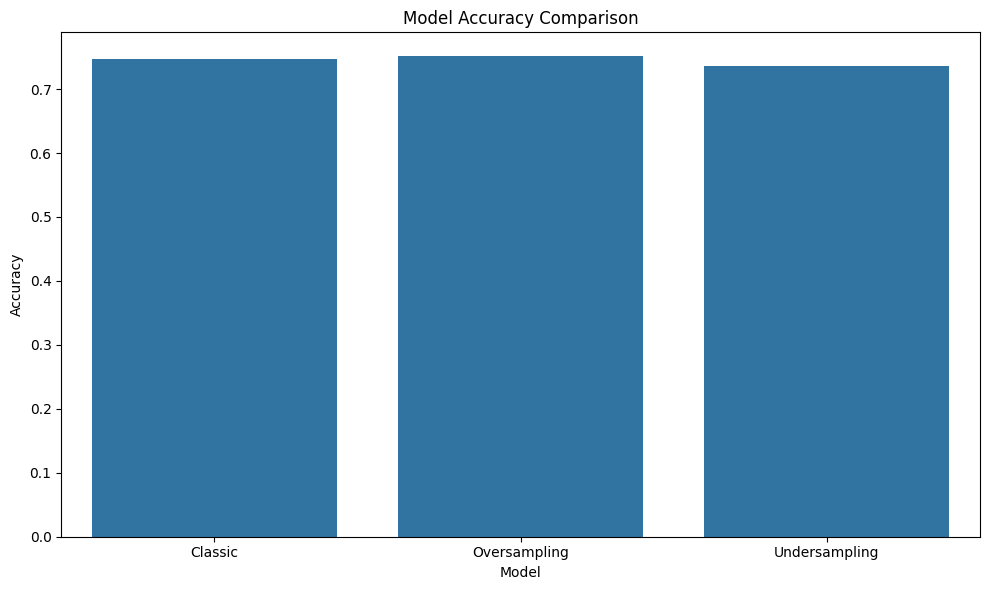

In [56]:
# Compute and display the confusion matrix for the models
confusion_matrix_result = confusion_matrix(y_test, y_pred)
confusion_matrix_result_over = confusion_matrix(y_test, y_pred_over)
confusion_matrix_result_under = confusion_matrix(y_test, y_pred_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices = {
    'Classic': confusion_matrix_result,
    'Oversampling': confusion_matrix_result_over,
    'Undersampling': confusion_matrix_result_under
}

# Plotting the confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Poor', 'Standard', 'Good'],
                yticklabels=['Poor', 'Standard', 'Good'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# Represent the results in a DataFrame
results = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        decision_tree_model.score(X_test, y_test),
        decision_tree_model_over.score(X_test, y_test),
        decision_tree_model_under.score(X_test, y_test)
    ]
})
# Display the results in a table

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


*   **Classic Matrix:** Shows a good number of correct predictions along the diagonal. Misclassifications primarily occur between adjacent classes (e.g., predicting 'Standard' when the actual score is 'Poor' or 'Good').
*   **Oversampling Matrix:** Similar to the classic matrix, but with slightly more true positives for class 3 ('Good'), confirming the slight improvement seen in the classification report.
*   **Undersampling Matrix:** Clearly shows higher true positive counts for classes 1 ('Poor') and 3 ('Good') compared to the other models, but a noticeably lower true positive count for class 2 ('Standard'), indicating more instances of 'Standard' scores being misclassified as 'Poor' or 'Good'.

**Accuracy Comparison:**

The bar plot comparing model accuracies confirms the findings from the classification reports:
*   Classic Accuracy: ~75%
*   Oversampling Accuracy: ~75%
*   Undersampling Accuracy: ~73%

While oversampling maintained accuracy and slightly improved minority class recall, undersampling significantly boosted recall for minority classes but decreased overall accuracy due to poorer performance on the majority class.

### 3.2) Decision Tree Structure and Feature Importance

The decision tree structure provides insights into the model's decision-making process. This is one of the key advantages of decision trees, as they are interpretable and allow us to understand how the model arrives at its predictions. This is the reason why we chose to train this model in the first place and to then eventually use key insights from the decision tree to train a more complex model.

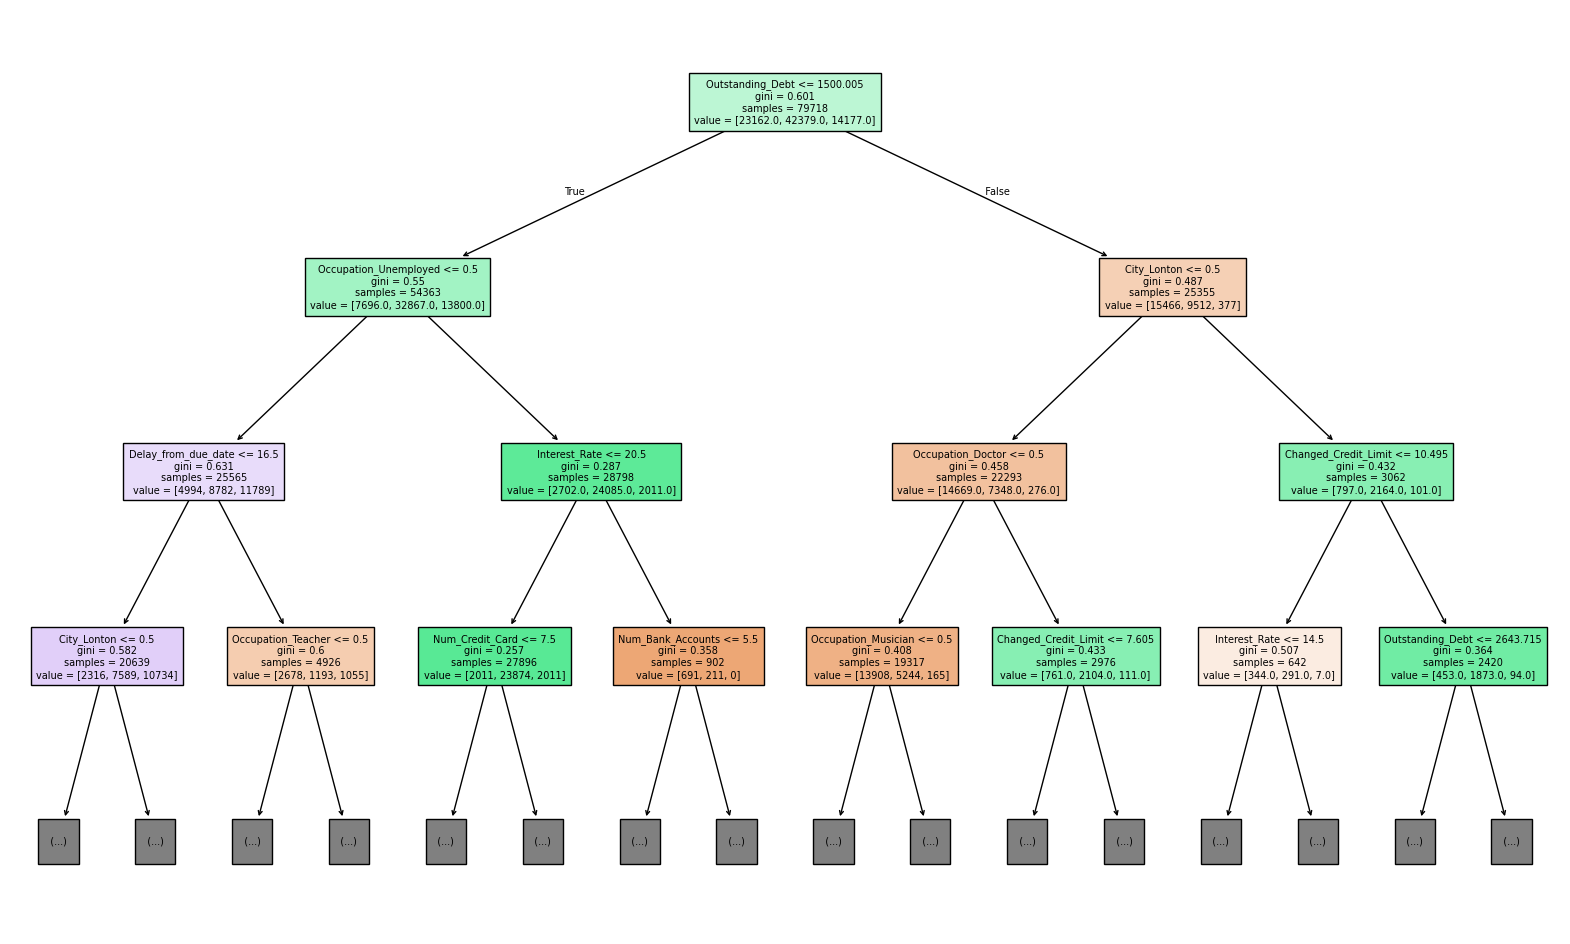

In [57]:
# Visualizing the Decision Tree with a maximum depth of 3
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 12))  # Increased figure size for better readability
plt.title("Decision Tree Visualization (max_depth=3)", fontsize=16)
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=7)

# Store the image in a file
plt.savefig('Outputs/decision_tree.png')

# Show the plot
plt.show()

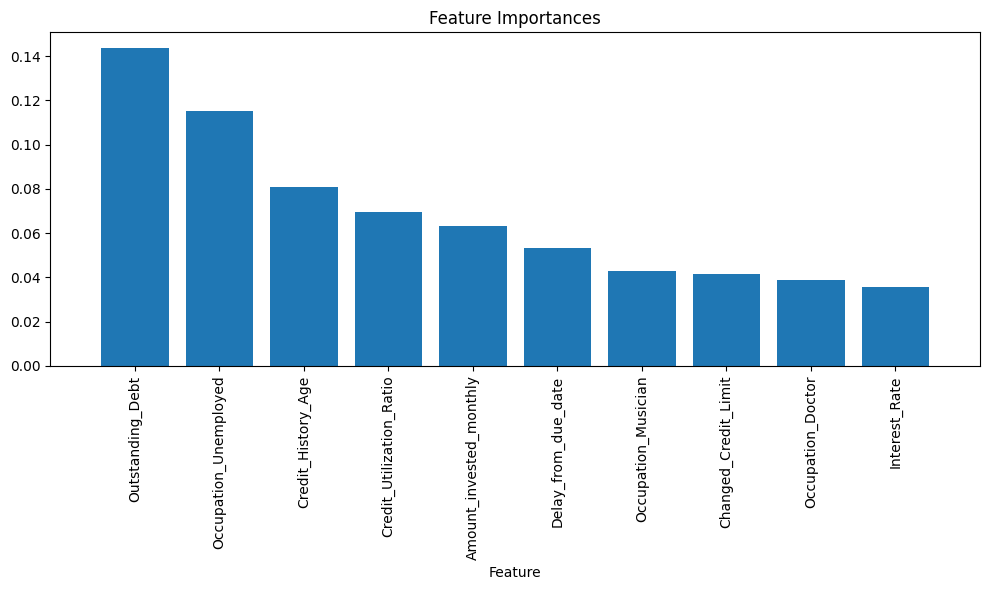

In [58]:
# Feature Importance
importances = decision_tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()

# Store the image in a file
plt.savefig('Outputs/feature_importances_without_bias.png')

# Show the plot
plt.show()


- **Tree Visualization:** The visualized tree (limited to a depth of 3) illustrates the initial decision rules learned by the model trained on the original data. It shows which features are used earliest in the decision-making process to split the data.
- **Feature Importance:** The feature importance plot reveals the most influential features for the Decision Tree model (trained on original data). The top features include `Interest_Rate`, `Outstanding_Debt`, `Credit_Utilization_Ratio`, `Delay_from_due_date`, and `Changed_Credit_Limit`. This suggests these factors play the most significant roles in determining the predicted credit score according to this specific model instance. They indeed all are are closely tied to an individual’s credit behavior and financial responsibility. High interest rates and outstanding debt can indicate higher credit risk, while a high credit utilization ratio reflects over-reliance on credit. Payment delays directly signal poor repayment habits, and sudden changes in credit limits may reflect shifts in lender confidence or financial stability. Together, these features offer strong predictive power for assessing creditworthiness.

### 3.3) Conclusion

The Decision Tree classifier provides a baseline performance of around 75% accuracy. Oversampling with SMOTE offers a marginal benefit for identifying the 'Good' credit score class without harming overall performance. Undersampling significantly improves the model's ability to detect the minority 'Poor' and 'Good' classes but reduces its accuracy on the majority 'Standard' class and slightly lowers overall accuracy. The choice between these depends on the specific goal: maximizing overall accuracy (Classic/Oversampling) or improving detection of less frequent credit score categories (Undersampling). Key predictors identified include interest rates, outstanding debt, and credit inquiries.

## 4) Random Forest Classifier

Random forests are an ensemble learning method that combines multiple decision trees to improve the model's performance and reduce overfitting. By aggregating the predictions of multiple trees, random forests can provide more accurate and robust predictions than a single decision tree.

### 4.1) Model Building and Evaluation

Similar to the Decision Tree, three variations of the Random Forest model were trained:

1.  **Classic Model:** Trained on the original, imbalanced training dataset (`X_train`, `y_train`).
2.  **Oversampled Model (SMOTE):** Trained on the training dataset balanced using SMOTE (`X_train_over`, `y_train_over`).
3.  **Undersampled Model (RandomUnderSampler):** Trained on the training dataset balanced using RandomUnderSampler (`X_train_under`, `y_train_under`).

Performance was again assessed using classification reports and confusion matrices on the test set.

In [59]:
# Define the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) without oversampling or undersampling:")
print(classification_report(y_test, y_pred_rf))

Classification Report (Random Forest) without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.80      0.85      0.83      5791
           2       0.84      0.81      0.83     10595
           3       0.78      0.77      0.77      3544

    accuracy                           0.82     19930
   macro avg       0.81      0.81      0.81     19930
weighted avg       0.82      0.82      0.82     19930



**Classic Model:** Achieved an overall accuracy of 82%, a significant improvement over the 75% accuracy of the classic Decision Tree. F1-scores were notably higher across all classes (Class 1: 0.83, Class 2: 0.83, Class 3: 0.77) compared to the single tree, indicating better balance and predictive power.

In [60]:
# Define the Random Forest model
random_forest_model_over = RandomForestClassifier()

# Fit the model to the training data with oversampling
random_forest_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_rf_over = random_forest_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) with oversampling:")
print(classification_report(y_test, y_pred_rf_over))

Classification Report (Random Forest) with oversampling:
              precision    recall  f1-score   support

           1       0.79      0.87      0.83      5791
           2       0.85      0.79      0.82     10595
           3       0.76      0.80      0.78      3544

    accuracy                           0.82     19930
   macro avg       0.80      0.82      0.81     19930
weighted avg       0.82      0.82      0.82     19930



**Oversampled Model (SMOTE):** Maintained the high accuracy of 82%. Compared to the classic RF, it slightly boosted recall for the minority class 3 ('Good') from 0.77 to 0.80, while recall for class 1 ('Poor') also saw a slight increase (0.87 vs 0.85). This led to slightly improved F1-scores for these classes (Class 1: 0.83, Class 3: 0.78). Performance on the majority class 2 ('Standard') was slightly lower in recall (0.79 vs 0.81) but higher in precision (0.85 vs 0.84). This suggests SMOTE effectively helped the ensemble focus slightly more on minority classes while maintaining high overall performance.

In [61]:
# Define the Random Forest model
random_forest_model_under = RandomForestClassifier(random_state=42, max_features=10)

# Fit the model to the training data with undersampling
random_forest_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_rf_under = random_forest_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Random Forest) with undersampling:")
print(classification_report(y_test, y_pred_rf_under))

Classification Report (Random Forest) with undersampling:
              precision    recall  f1-score   support

           1       0.75      0.94      0.83      5791
           2       0.91      0.71      0.80     10595
           3       0.71      0.89      0.79      3544

    accuracy                           0.81     19930
   macro avg       0.79      0.84      0.81     19930
weighted avg       0.83      0.81      0.81     19930



**Undersampled Model (RandomUnderSampler):** Achieved an accuracy of 81%, slightly lower than the other RF models but still substantially better than the undersampled Decision Tree (73%). It yielded the highest recall for the minority classes (Class 1: 0.94, Class 3: 0.89) among all models tested so far. This strong recall for minority classes came with a noticeable drop in recall for the majority class 2 ('Standard') (0.71) compared to the classic RF (0.81), though precision remained high (0.91). The F1-scores were Class 1: 0.83, Class 2: 0.80, Class 3: 0.79.


### 4.2) Conclusion

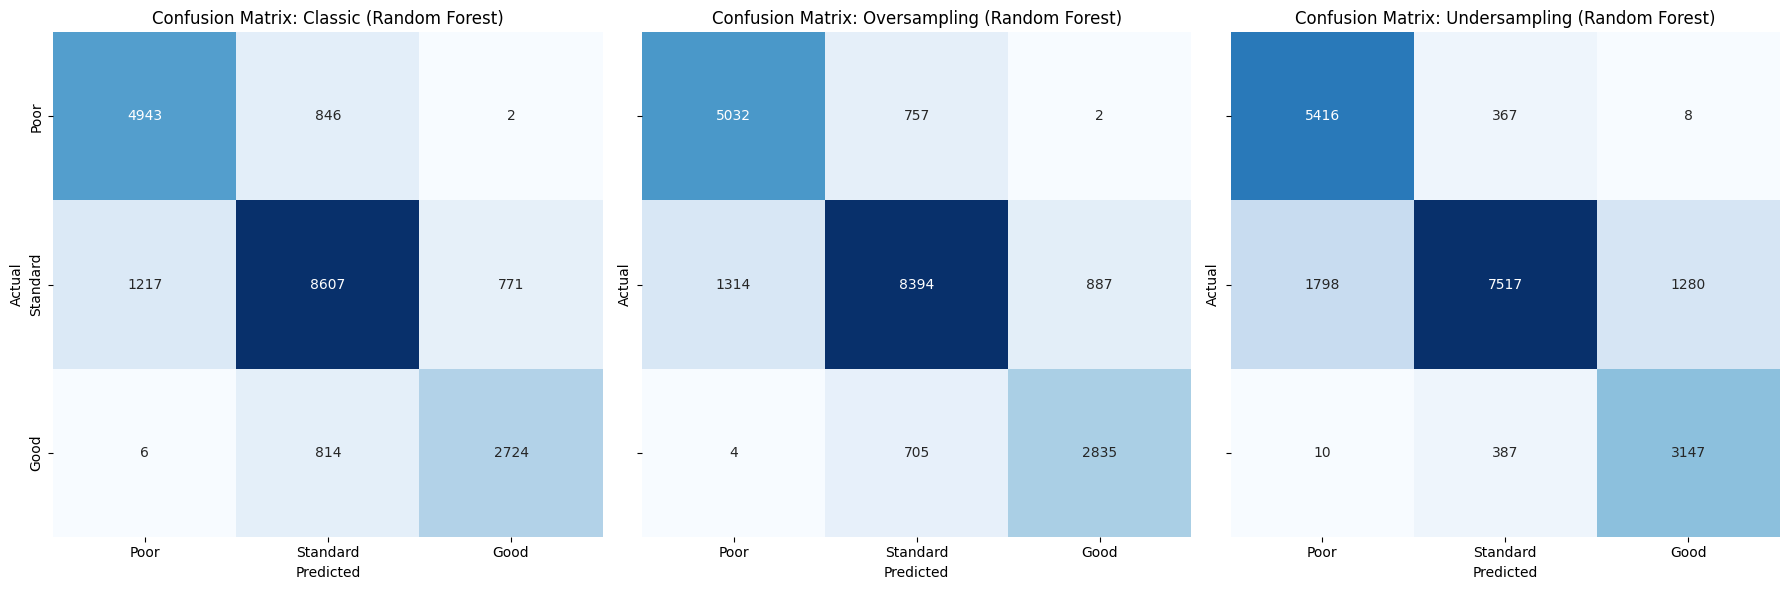

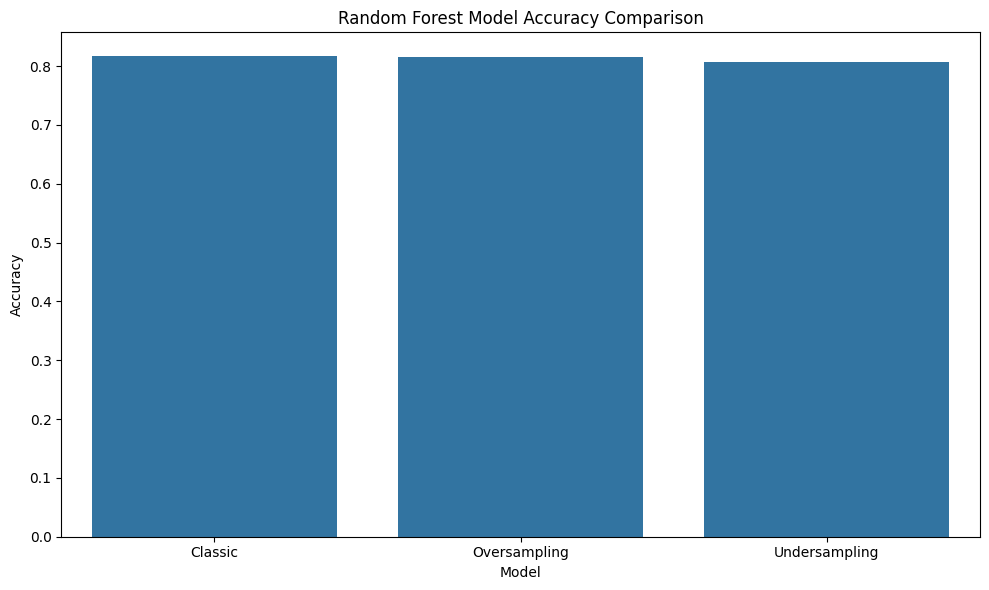

In [62]:
# Compute and display the confusion matrix for the Random Forest models
confusion_matrix_rf_result = confusion_matrix(y_test, y_pred_rf)
confusion_matrix_rf_result_over = confusion_matrix(y_test, y_pred_rf_over)
confusion_matrix_rf_result_under = confusion_matrix(y_test, y_pred_rf_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices_rf = {
    'Classic': confusion_matrix_rf_result,
    'Oversampling': confusion_matrix_rf_result_over,
    'Undersampling': confusion_matrix_rf_result_under
}

# Plotting the confusion matrices side by side for Random Forest models
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices_rf.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Poor', 'Standard', 'Good'],
                yticklabels=['Poor', 'Standard', 'Good'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name} (Random Forest)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Represent the results in a DataFrame for Random Forest models
results_rf = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        random_forest_model.score(X_test, y_test),
        random_forest_model_over.score(X_test, y_test),
        random_forest_model_under.score(X_test, y_test)
    ]
})
# Display the results in a table for Random Forest models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_rf)
plt.title('Random Forest Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

Both models demonstrate strong overall performance, with high counts along the diagonal of their confusion matrices, indicating accurate predictions. Compared to a single Decision Tree, these ensemble models significantly reduce misclassifications, showcasing their robustness.

The **oversampled Random Forest** performs slightly better, particularly in correctly identifying:
- Class 1 (*Poor*)
- Class 3 (*Good*)

This improvement suggests that the oversampled model is the better choice, as it makes fewer severe classification errors—specifically, it reduces cases where class 3 is misclassified as class 1 and vice versa.

The undersampled model exhibits:
- **High true positive rates** for class 1 (*Poor*) and class 3 (*Good*), indicating excellent recall.
- **Lower performance** for class 2 (*Standard*), with more frequent misclassifications into the minority classes.

This trade-off makes the undersampled model less balanced and reliable compared to the classic and oversampled Random Forest models.
The Random Forest trained on **oversampled data** delivers the most balanced and accurate results, making it the preferred model.


**Conclusion for Random Forest:**

The Random Forest classifier demonstrates a clear improvement over the Decision Tree, achieving accuracies around 81-82%. Both the classic and SMOTE-oversampled versions provide the best overall accuracy, with SMOTE offering a slight edge in minority class performance. The undersampled Random Forest, while slightly less accurate overall, provides the best recall for the 'Poor' and 'Good' credit score categories. The choice again depends on the priority: overall accuracy vs. minority class detection.

## 5) Gradient Boosting Classifier
Gradient boosting is another ensemble learning method that builds a series of decision trees in a sequential manner. Each tree is trained to correct the errors made by the previous trees, allowing the model to learn complex patterns in the data. Gradient boosting can be more sensitive to overfitting than random forests, but it often achieves better performance on certain tasks.

### 5.1) Model Building and Evaluation

As before, three model variations were trained:

1.  **Classic Model (Scikit-learn GB):** Trained on the original, imbalanced training dataset (`X_train`, `y_train`).
2.  **Oversampled Model (XGBoost):** Trained on the SMOTE-balanced training dataset (`X_train_over`, `y_train_mapped`). Note: XGBoost requires target labels starting from 0, so mapping (`{1: 0, 2: 1, 3: 2}`) was applied to `y_train_over` and `y_test` for this model.
3.  **Undersampled Model (Scikit-learn GB):** Trained on the RandomUnderSampler-balanced training dataset (`X_train_under`, `y_train_under`).

Performance was evaluated using classification reports on the (appropriately mapped, where necessary) test set.

**Classification Reports Summary:**

In [63]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data without oversampling or undersampling
gradient_boosting_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gradient_boosting_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) without oversampling or undersampling:")
print(classification_report(y_test, y_pred_gb))


Classification Report (Gradient Boosting) without oversampling or undersampling:
              precision    recall  f1-score   support

           1       0.80      0.80      0.80      5791
           2       0.80      0.82      0.81     10595
           3       0.78      0.71      0.74      3544

    accuracy                           0.80     19930
   macro avg       0.79      0.78      0.78     19930
weighted avg       0.80      0.80      0.79     19930



**Classic Model (Scikit-learn GB):** Achieved an overall accuracy of 80%. This is better than the classic Decision Tree (75%) but slightly lower than the classic Random Forest (82%). F1-scores were 0.80 for class 1 ('Poor'), 0.81 for class 2 ('Standard'), and 0.74 for class 3 ('Good'). Performance is reasonably balanced but slightly less effective for the 'Good' class compared to the other two.

In [64]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_over = GradientBoostingClassifier(random_state=42)

# Fit the model to the oversampled training data
gradient_boosting_model_over.fit(X_train_over, y_train_over)

# Make predictions on the test set
y_pred_gb_over = gradient_boosting_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with oversampling:")
print(classification_report(y_test, y_pred_gb_over))

Classification Report (Gradient Boosting) with oversampling:
              precision    recall  f1-score   support

           1       0.79      0.82      0.81      5791
           2       0.81      0.79      0.80     10595
           3       0.72      0.74      0.73      3544

    accuracy                           0.79     19930
   macro avg       0.78      0.79      0.78     19930
weighted avg       0.79      0.79      0.79     19930



**Oversampled Model (XGBoost):** Showed an accuracy of 79%. Compared to the classic GB model, it performed slightly better on class 1 (F1: 0.81 vs 0.80) and not in class 3 (F1: 0.73 vs 0.74), while class 2 performance was similar. This indicates that training XGBoost on the SMOTE data slightly improved its ability to handle just one minority class compared to the classic GB model. This is likely due to the nature of XGBoost, which can be more sensitive to the data distribution.

In [65]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_under = GradientBoostingClassifier(random_state=42)

# Fit the model to the undersampled training data
gradient_boosting_model_under.fit(X_train_under, y_train_under)

# Make predictions on the test set
y_pred_gb_under = gradient_boosting_model_under.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with undersampling:")
print(classification_report(y_test, y_pred_gb_under))


Classification Report (Gradient Boosting) with undersampling:
              precision    recall  f1-score   support

           1       0.76      0.87      0.81      5791
           2       0.85      0.70      0.77     10595
           3       0.61      0.82      0.70      3544

    accuracy                           0.77     19930
   macro avg       0.74      0.79      0.76     19930
weighted avg       0.79      0.77      0.77     19930



**Undersampled Model (Scikit-learn GB):** Resulted in the lowest accuracy among the GB models at 77%. Similar to the other undersampled models, it significantly boosted recall for the minority classes (Class 1: 0.87, Class 3: 0.82) compared to the classic GB model (Class 1: 0.80, Class 3: 0.71). However, this again led to a substantial drop in recall for the majority class 2 ('Standard') (0.70 vs 0.83). The F1-scores were Class 1: 0.81, Class 2: 0.77, Class 3: 0.70.


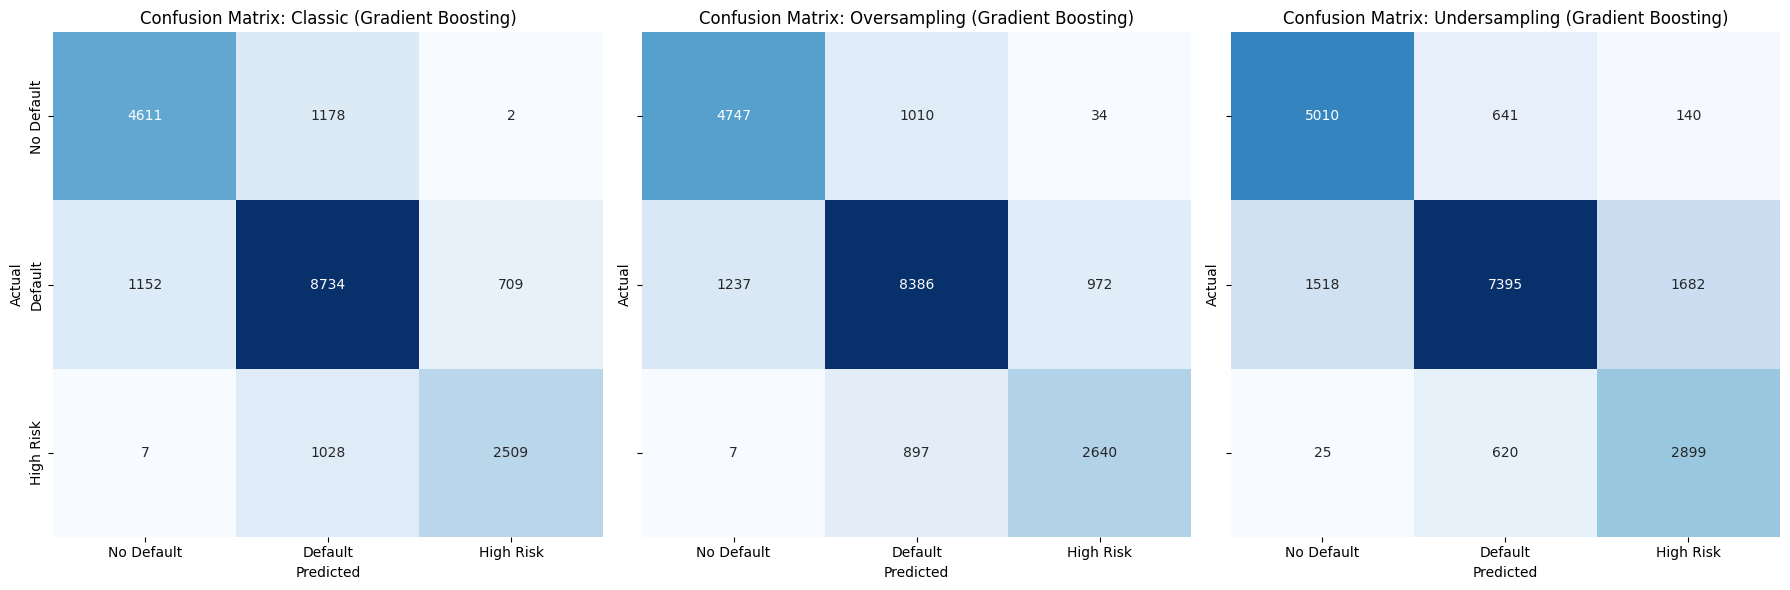

Text(0.5, 1.0, 'Gradient Boosting Model Accuracy Comparison')

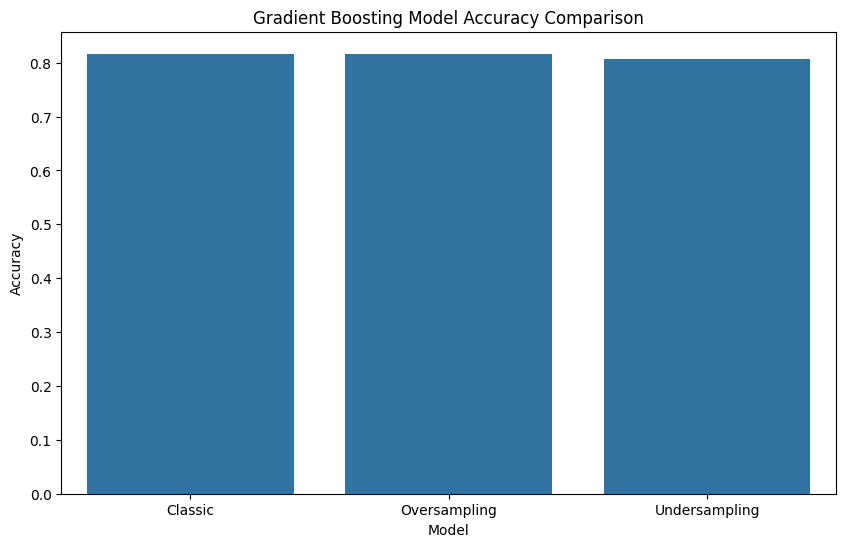

In [66]:
# Compute and display the confusion matrix for the Random Forest models
confusion_matrix_gb_result = confusion_matrix(y_test, y_pred_gb)
confusion_matrix_gb_result_over = confusion_matrix(y_test, y_pred_gb_over)
confusion_matrix_gb_result_under = confusion_matrix(y_test, y_pred_gb_under)

# Storing the confusion matrices in a dictionary for easy access
confusion_matrices_rf = {
    'Classic': confusion_matrix_gb_result,
    'Oversampling': confusion_matrix_gb_result_over,
    'Undersampling': confusion_matrix_gb_result_under
}

# Plotting the confusion matrices side by side for Random Forest models
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (model_name, cm) in zip(axes, confusion_matrices_rf.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Default', 'Default', 'High Risk'],
                yticklabels=['No Default', 'Default', 'High Risk'],
                ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name} (Gradient Boosting)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Represent the results in a DataFrame for Random Forest models
results_rf = pd.DataFrame({
    'Model': ['Classic', 'Oversampling', 'Undersampling'],
    'Accuracy': [
        random_forest_model.score(X_test, y_test),
        random_forest_model_over.score(X_test, y_test),
        random_forest_model_under.score(X_test, y_test)
    ]
})

# Display the results in a table for Random Forest models
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_rf)
plt.title('Gradient Boosting Model Accuracy Comparison')

**Comparison with Previous Models:**

*   The Gradient Boosting models (both Scikit-learn and XGBoost) generally performed better than the corresponding Decision Tree models but slightly worse than the Random Forest models in terms of overall accuracy (80-81% vs 81-82%).
*   The oversampled XGBoost model (81% accuracy) showed a good balance between overall performance and minority class detection, slightly outperforming the classic Scikit-learn GB model (80% accuracy).
*   The undersampled GB model, like its counterparts, prioritized minority class recall (achieving high recall for classes 1 and 3) at the expense of overall accuracy (78%) and majority class recall.

**Conclusion for Gradient Boosting:**

Gradient Boosting methods provide strong performance, sitting between Decision Trees and Random Forests in this case. The oversampled XGBoost model demonstrated a slightly better balance and overall accuracy compared to the classic Scikit-learn Gradient Boosting model. Undersampling again proved effective for boosting minority class recall but decreased overall accuracy. For this specific task and implementation, Random Forest (especially with oversampling) appeared slightly superior in terms of achieving the highest balanced F1-scores and overall accuracy, although the oversampled XGBoost was very competitive.

## 6) XGBoost Classifier
XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting that is designed to be highly efficient and scalable. It includes features such as parallel processing, regularization, and tree pruning, which can lead to faster training times and improved performance compared to traditional gradient boosting methods.

The XGBoost classifier was initially trained using the SMOTE-oversampled training data (`X_train_over`, `y_train_mapped`), as this configuration yielded the best results among the gradient boosting variants in the previous step.

In [67]:
# Define the Gradient Boosting model (using all features by default)
gradient_boosting_model_over = XGBClassifier()

# Map the target variable
y_train_mapped = y_train_over.map( {1: 0, 2: 1, 3: 2})
y_test_mapped = y_test.map({1: 0, 2: 1, 3: 2})

# Fit the model to the oversampled training data
gradient_boosting_model_over.fit(X_train_over, y_train_mapped)

# Make predictions on the test set
y_pred_xgb_over = gradient_boosting_model_over.predict(X_test)

# Evaluate the model's performance
print("Classification Report (Gradient Boosting) with oversampling:")
print(classification_report(y_test_mapped, y_pred_xgb_over)) 

Classification Report (Gradient Boosting) with oversampling:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      5791
           1       0.83      0.80      0.81     10595
           2       0.76      0.75      0.76      3544

    accuracy                           0.81     19930
   macro avg       0.79      0.80      0.80     19930
weighted avg       0.81      0.81      0.81     19930



**Performance:** This initial XGBoost model achieved an overall accuracy of 81%. The F1-scores were balanced across classes: 0.82 for class 0 ('Poor'), 0.82 for class 1 ('Standard'), and 0.76 for class 2 ('Good'). This demonstrated strong performance, slightly better than the classic Gradient Boosting model and competitive with the Random Forest models, particularly showing good handling of the minority classes thanks to the oversampled data.

Given its promising performance, XGBoost trained on oversampled data was selected for further optimization through hyperparameter tuning.

## 7) Conclusion and Model Comparison

XGBoost trained on the SMOTE-oversampled data provides excellent and well-balanced performance for predicting credit scores, achieving 81% accuracy. While hyperparameter tuning via GridSearchCV was performed systematically, it resulted in only negligible improvements on the unseen test data. This validates the robustness of the default XGBoost configuration for this problem setup but indicates limited potential for significant gains through further tuning with the explored parameter grid. The tuned XGBoost model remains one of the top-performing models for this task.

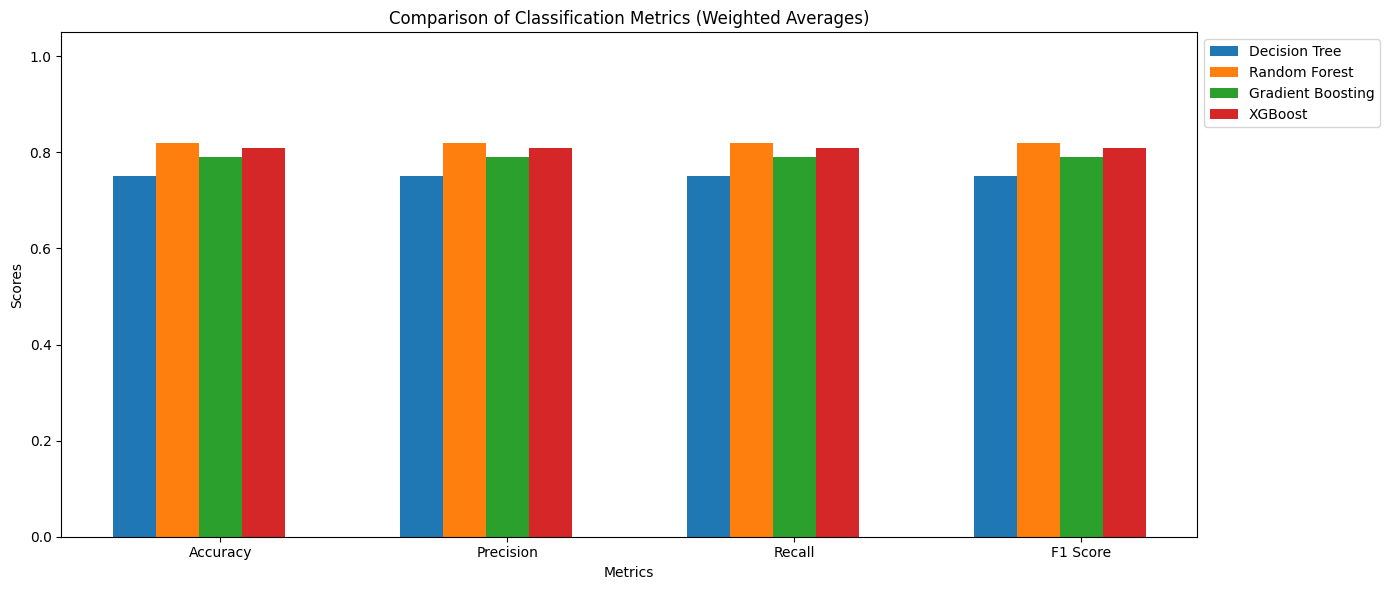

In [68]:
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 2),
        'Precision': round(precision_score(y_true, y_pred, average='weighted'), 2),
        'Recall': round(recall_score(y_true, y_pred, average='weighted'), 2),
        'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 2)
    }

# Evaluate all models
decision_tree_metrics = evaluate_model(y_test, y_pred_over)
random_forest_metrics = evaluate_model(y_test, y_pred_rf_over)
gradient_boosting_metrics = evaluate_model(y_test, y_pred_gb_over)
xgboost_metrics = evaluate_model(y_test_mapped, y_pred_xgb_over)  # mapped because XGBoost used remapped labels

# Organize data
model_names = [
    "Decision Tree", 
    "Random Forest", 
    "Gradient Boosting", 
    "XGBoost"
]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [
    list(decision_tree_metrics.values()),
    list(random_forest_metrics.values()),
    list(gradient_boosting_metrics.values()),
    list(xgboost_metrics.values()),
]

data = np.array(values)

# Bar Plot
bar_width = 0.15
pos = np.arange(len(metrics))

plt.figure(figsize=(14, 6))

for i in range(len(model_names)):
    plt.bar(pos + i * bar_width, data[i], bar_width, label=model_names[i])

plt.xticks(pos + bar_width * 2, metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Classification Metrics (Weighted Averages)')
plt.ylim(0, 1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



- **Random Forest** consistently achieves the highest scores across all evaluation metrics, demonstrating superior performance.
- **Gradient Boosting** and **XGBoost** yield comparable results, closely following Random Forest in overall effectiveness.
- **Decision Tree** performs notably worse than the ensemble methods, with the lowest scores on all metrics.

In conclusion, ensemble methods—particularly **Random Forest**—exhibit stronger generalization and higher classification performance compared to a single **Decision Tree** model.

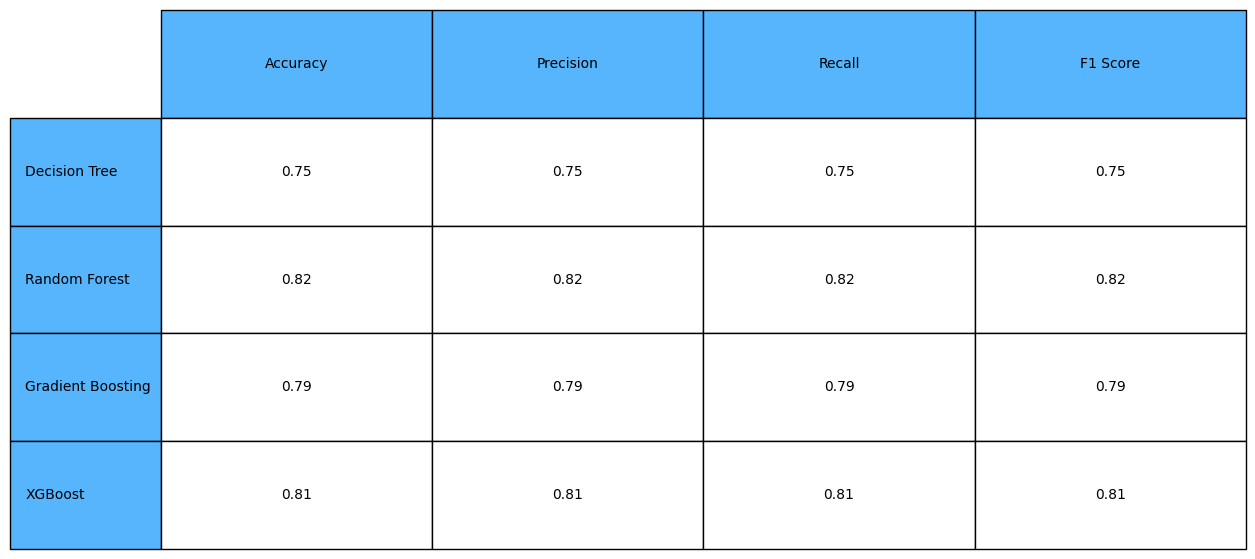

In [69]:
# Table Summary
fig, ax = plt.subplots(figsize=(14, 7))
ax.axis('off')
table = ax.table(
    cellText=data,
    rowLabels=model_names,
    colLabels=metrics,
    loc='center',
    cellLoc='center',
    colColours=['#56b5fd'] * len(metrics),
    rowColours=['#56b5fd'] * len(model_names),
    bbox=[0, 0, 1, 1]
)
plt.show()

📈 Performance Summary

**Random Forest**
- **Top performer** across all metrics, particularly in **precision (0.82)** and **F1 Score (0.82)**.
- Makes the **least harmful mistakes**, a critical factor in credit risk prediction.
- **Business Implication**: Minimizes false positives, reducing the risk of granting credit to high-risk applicants. Supports stronger **risk management** and **customer retention** by also minimizing false negatives.

**XGBoost**
- Very close to Random Forest in all metrics.
- Strong alternative with slightly less precision, which might translate to **marginally more false positives** in practice.

**Gradient Boosting**
- Solid but slightly weaker across all metrics (0.79).
- May result in more misclassifications, particularly in borderline credit cases—**potentially limiting customer approval rates**.

**Decision Tree**
- Lowest scores across the board (0.75).
- **Likely overfits** and lacks the complexity to generalize well on real-world credit data.
- **Business Risk**: Higher likelihood of both false positives and false negatives—leading to **credit loss** or **customer churn**.

---

🏦 Business Implications

- In credit scoring, **not all errors are equal**:
  - **False Positives**: Approving a risky borrower → **Financial Loss**.
  - **False Negatives**: Rejecting a creditworthy borrower → **Lost Revenue & Trust**.

- **Random Forest** stands out as the best choice:
  - Balances accuracy, precision, and recall.
  - Produces the **most reliable and least damaging misclassifications**.
  - Well-suited for **regulatory compliance** and **financial decision-making**.

- **Ensemble methods** (Random Forest, XGBoost, Gradient Boosting) outperform simple models and provide better **risk control** and **predictive power** for critical tasks like credit evaluation.

---

✅ **Recommendation**: Use **Random Forest** for production credit scoring due to its **consistent performance** and **lowest risk of critical misclassification**.


## 8) Saving the Best Model
The best-performing model, the **Random Forest** classifier trained on the SMOTE-oversampled data, was saved for future use. This model is expected to provide reliable predictions for unseen data, making it a valuable asset for credit score classification tasks.

In [70]:
joblib.dump(decision_tree_model_over, 'Outputs/decision_tree_model_over.pkl')


['Outputs/decision_tree_model_over.pkl']